---
### torch가 안돼서 정말 애먹었는데, 아직도 해결을 못했다 ㅠㅠ 이유가 뭐야 대체 !!!!!!!!!!!!!!!!!!
결국 코랩으로 넘어갔다...

---

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 사용할 폴더로 이동
%cd /content/gdrive/MyDrive/빅데이터/12. 자연어 처리/day2

/content/gdrive/MyDrive/빅데이터/12. 자연어 처리/day2


## Transformer 구조 구현

In [ ]:
!pip install sentencepiece

#### 1. 데이터 확인

In [ ]:
# data를 저장할 directory 확인
data_dir = "./data"

#### 2. Imports

In [ ]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

#### 3. 폴더의 목록을 확인
data_dir 목록을 확인 합니다.

In [ ]:
for f in os.listdir(data_dir):
  print(f)

kowiki.model
kowiki.vocab
kowiki.txt


#### 4. Vocab 및 입력
Sentencepiece를 활용해 미리 만든 voca를 로드함  
: wiki corpus로 만들어 놓음

로딩된 vocab을 이용해 input을 만듭니다.

In [ ]:
# vocab 만들기
import pandas as pd
import sentencepiece as spm
import csv

In [ ]:
# 모델 로드
vocab_file = './data/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

In [ ]:
# 문장 작성
lines = [
    "여름은 더워요.",
    "감기 조심하세요."
]

# ecoding : encode_as_ids
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line) # 토큰
    ids = vocab.encode_as_ids(line) #ids
    inputs.append(torch.tensor(ids))
    print(pieces)
    print(ids)

# 입력 길이에 대해 padding
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)

# input 확인
print(inputs.size()) # 배치사이즈, 시퀀스 길이=max_lengh
print(inputs)

['▁여름', '은', '▁더', '워', '요', '.']
[2395, 3744, 211, 4081, 3902, 3730]
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
[199, 3746, 54, 3974, 3736, 3826, 3902, 3730]
torch.Size([2, 8])
tensor([[2395, 3744,  211, 4081, 3902, 3730,    0,    0],
        [ 199, 3746,   54, 3974, 3736, 3826, 3902, 3730]])


#### 5. Embedding

#### - Input Embedding

In [ ]:
n_vocab = len(vocab)
print(n_vocab)
d_hidn = 128 # 내부에서 쓸 벡터 사이즈
nn_emb = nn.Embedding(n_vocab, d_hidn)
input_embs = nn_emb(inputs)
print(input_embs.size())

8007
torch.Size([2, 8, 128])


##### - Position Embedding

1. 문장의 position 별 angle 값을 구함  
2. 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.  
3. 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

In [ ]:
""" sinusoid position embedding """# 각 포지션 별 앵글값에 따라 sin, cos 계산
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]
    # 각 postion에 대해 dimension에 때라 angle 값을 구함
    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # 짝수에 해당하는 디맨션
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # 홀수에 해당하는 디맨션

    return sinusoid_table

In [ ]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)
pos_encoding.shape
# embedding 그림 출력
# plt.pcolormesh(pos_encoding, cmap='RdBu')
# plt.xlabel('Depth')
# plt.xlim((0, d_hidn))
# plt.ylabel('Position')
# plt.colorbar()
# plt.show()

(64, 128)

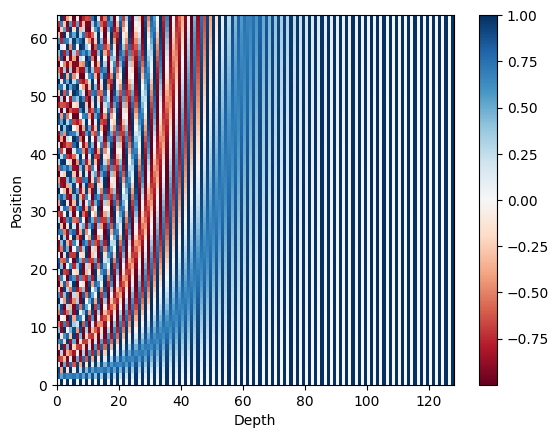

In [ ]:
# embedding 그림 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
# position embedding 구성
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze= True)

print(inputs.size())
#position masking 하기
positions= torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1 # 인풋값의 포지션과 똑같은 데이터를 만들기
print(positions)

pos_mask = inputs.eq(0) # 패딩을 찾는 method
print(pos_mask)

positions.masked_fill_(pos_mask, 0) # True 인 부분을 0으로 바꿔주기
print(positions)
pos_embs = nn_pos(positions)
print(pos_embs)
print(pos_embs.size())

torch.Size([2, 8])
tensor([[1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8]])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
tensor([[[ 8.4147e-01,  5.4030e-01,  7.6172e-01,  ...,  1.0000e+00,
           1.1548e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.8705e-01,  ...,  1.0000e+00,
           2.3096e-04,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  5.1731e-01,  ...,  1.0000e+00,
           3.4643e-04,  1.0000e+00],
         ...,
         [-2.7942e-01,  9.6017e-01, -8.8542e-01,  ...,  1.0000e+00,
           6.9287e-04,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00]],

        [[ 8.4147e-01,  5.4030e-01,  7.6172e-01,  ...,  1.0000e+

In [ ]:
# 초기 input 값 구성
input_sums = input_embs + pos_embs
print(input_sums)
print(input_sums.size())

tensor([[[ 2.7659, -0.1473,  0.8363,  ...,  0.4827,  0.4569,  1.7397],
         [ 0.9082, -1.4718,  1.5857,  ...,  0.3003, -1.0929,  1.6831],
         [ 0.6097, -1.0963,  2.9839,  ...,  1.2536,  0.6117,  1.5453],
         ...,
         [-0.4421,  1.8075, -0.4710,  ...,  3.5239, -1.4905, -0.4633],
         [-0.2665,  1.5177,  1.8985,  ...,  3.0449,  0.5095,  2.5040],
         [-0.2665,  1.5177,  1.8985,  ...,  3.0449,  0.5095,  2.5040]],

        [[-2.2270,  0.1558, -0.4387,  ...,  0.4462, -0.1343,  2.1542],
         [ 0.6010, -2.4929,  1.0810,  ...,  1.1188, -0.2239,  0.4621],
         [-0.0309, -0.0280,  0.3750,  ...,  1.6910,  0.8418,  0.9649],
         ...,
         [-0.2172,  2.0274, -0.2276,  ...,  0.2962, -0.0060,  0.1345],
         [ 0.8739,  1.9905, -1.2672,  ...,  2.8025, -1.3227, -0.0977],
         [ 0.8266,  0.7019,  1.0152,  ...,  3.5239, -1.4903, -0.4633]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 8, 128])


#### 6. Scale Dot Product Attention

##### Input

In [ ]:
# input 입력 값을 만드는 과정
Q = input_sums
K = input_sums
V = input_sums

# attention에 대한 masking 구성
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1)) # unsqueeze 차원 추가 함수 # expand 원하는 형태로 사이즈? 추가 하는 함수
print(attn_mask)
print(attn_mask.size())

tensor([[[False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True]],

        [[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, F

##### Q * K-transpose

In [ ]:
# Q * K 내적
# q.size = (2, 8, 128)
# k.size = (2, 8, 128)
scores = torch.matmul(Q, K.transpose(-1, -2))
print(K)
print(K.transpose(-1, -2))
print(scores)
print(scores.size())

tensor([[[ 2.7659, -0.1473,  0.8363,  ...,  0.4827,  0.4569,  1.7397],
         [ 0.9082, -1.4718,  1.5857,  ...,  0.3003, -1.0929,  1.6831],
         [ 0.6097, -1.0963,  2.9839,  ...,  1.2536,  0.6117,  1.5453],
         ...,
         [-0.4421,  1.8075, -0.4710,  ...,  3.5239, -1.4905, -0.4633],
         [-0.2665,  1.5177,  1.8985,  ...,  3.0449,  0.5095,  2.5040],
         [-0.2665,  1.5177,  1.8985,  ...,  3.0449,  0.5095,  2.5040]],

        [[-2.2270,  0.1558, -0.4387,  ...,  0.4462, -0.1343,  2.1542],
         [ 0.6010, -2.4929,  1.0810,  ...,  1.1188, -0.2239,  0.4621],
         [-0.0309, -0.0280,  0.3750,  ...,  1.6910,  0.8418,  0.9649],
         ...,
         [-0.2172,  2.0274, -0.2276,  ...,  0.2962, -0.0060,  0.1345],
         [ 0.8739,  1.9905, -1.2672,  ...,  2.8025, -1.3227, -0.0977],
         [ 0.8266,  0.7019,  1.0152,  ...,  3.5239, -1.4903, -0.4633]]],
       grad_fn=<AddBackward0>)
tensor([[[ 2.7659,  0.9082,  0.6097,  ..., -0.4421, -0.2665, -0.2665],
         [-0.1

##### Scale

In [ ]:
# scaled dot
d_head = 64 # 헤드 별 hidden size (D_hidn / N_head) N_head : 2
scores = scores.mul_(1/d_head**0.5)
print(scores)
print(scores.size())

tensor([[[24.5350,  7.7181,  6.4726,  4.4574,  5.4285,  4.8723,  6.2927,
           6.2927],
         [ 7.7181, 22.3182,  9.5566,  6.1974,  2.8991,  5.7743,  5.3210,
           5.3210],
         [ 6.4726,  9.5566, 25.3310,  8.4186,  6.2763,  7.3010, 10.5229,
          10.5229],
         [ 4.4574,  6.1974,  8.4186, 23.5176,  6.1662,  5.7699,  6.6814,
           6.6814],
         [ 5.4285,  2.8991,  6.2763,  6.1662, 25.9136,  8.4262,  5.4445,
           5.4445],
         [ 4.8723,  5.7743,  7.3010,  5.7699,  8.4262, 27.7877,  5.5034,
           5.5034],
         [ 6.2927,  5.3210, 10.5229,  6.6814,  5.4445,  5.5034, 26.2628,
          26.2628],
         [ 6.2927,  5.3210, 10.5229,  6.6814,  5.4445,  5.5034, 26.2628,
          26.2628]],

        [[24.7896,  3.9870,  7.4966,  2.4102,  4.3707,  7.1746,  4.6311,
           6.4468],
         [ 3.9870, 19.8513,  5.1298,  5.6937,  4.0163,  4.5557,  5.1366,
           7.4674],
         [ 7.4966,  5.1298, 21.6748,  6.5368,  9.1654,  5.7896,  5.7

##### Mask (Opt.)

In [ ]:
# masking
scores.masked_fill_(attn_mask, -1e9) # 엄청 작은 숫자로 가중치를 줌
print(scores)
print(scores.size())

tensor([[[ 2.4535e+01,  7.7181e+00,  6.4726e+00,  4.4574e+00,  5.4285e+00,
           4.8723e+00, -1.0000e+09, -1.0000e+09],
         [ 7.7181e+00,  2.2318e+01,  9.5566e+00,  6.1974e+00,  2.8991e+00,
           5.7743e+00, -1.0000e+09, -1.0000e+09],
         [ 6.4726e+00,  9.5566e+00,  2.5331e+01,  8.4186e+00,  6.2763e+00,
           7.3010e+00, -1.0000e+09, -1.0000e+09],
         [ 4.4574e+00,  6.1974e+00,  8.4186e+00,  2.3518e+01,  6.1662e+00,
           5.7699e+00, -1.0000e+09, -1.0000e+09],
         [ 5.4285e+00,  2.8991e+00,  6.2763e+00,  6.1662e+00,  2.5914e+01,
           8.4262e+00, -1.0000e+09, -1.0000e+09],
         [ 4.8723e+00,  5.7743e+00,  7.3010e+00,  5.7699e+00,  8.4262e+00,
           2.7788e+01, -1.0000e+09, -1.0000e+09],
         [ 6.2927e+00,  5.3210e+00,  1.0523e+01,  6.6814e+00,  5.4445e+00,
           5.5034e+00, -1.0000e+09, -1.0000e+09],
         [ 6.2927e+00,  5.3210e+00,  1.0523e+01,  6.6814e+00,  5.4445e+00,
           5.5034e+00, -1.0000e+09, -1.0000e+09]],

##### Softmax

In [ ]:
# softmax 적용
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob)

torch.Size([2, 8, 8])
tensor([[[1.0000e+00, 4.9721e-08, 1.4309e-08, 1.9073e-09, 5.0369e-09,
          2.8880e-09, 0.0000e+00, 0.0000e+00],
         [4.5631e-07, 1.0000e+00, 2.8688e-06, 9.9731e-08, 3.6845e-09,
          6.5322e-08, 0.0000e+00, 0.0000e+00],
         [6.4553e-09, 1.4102e-07, 1.0000e+00, 4.5190e-08, 5.3046e-09,
          1.4780e-08, 0.0000e+00, 0.0000e+00],
         [5.2755e-09, 3.0057e-08, 2.7707e-07, 1.0000e+00, 2.9134e-08,
          1.9601e-08, 0.0000e+00, 0.0000e+00],
         [1.2689e-09, 1.0114e-10, 2.9621e-09, 2.6534e-09, 1.0000e+00,
          2.5427e-08, 0.0000e+00, 0.0000e+00],
         [1.1168e-10, 2.7524e-10, 1.2669e-09, 2.7404e-10, 3.9032e-09,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.3799e-02, 5.2226e-03, 9.4845e-01, 2.0355e-02, 5.9090e-03,
          6.2674e-03, 0.0000e+00, 0.0000e+00],
         [1.3799e-02, 5.2226e-03, 9.4845e-01, 2.0355e-02, 5.9090e-03,
          6.2674e-03, 0.0000e+00, 0.0000e+00]],

        [[1.0000e+00, 9.2377e-10, 3.0887

##### atten_prov * V

In [ ]:
context = torch.matmul(attn_prob, V)
print(context.size())
print(context)

torch.Size([2, 8, 128])
tensor([[[ 2.7659, -0.1473,  0.8363,  ...,  0.4827,  0.4569,  1.7397],
         [ 0.9082, -1.4718,  1.5857,  ...,  0.3003, -1.0929,  1.6831],
         [ 0.6097, -1.0963,  2.9839,  ...,  1.2536,  0.6117,  1.5453],
         ...,
         [-0.4421,  1.8075, -0.4710,  ...,  3.5239, -1.4905, -0.4633],
         [ 0.5737, -1.0372,  2.8316,  ...,  1.2445,  0.5755,  1.5000],
         [ 0.5737, -1.0372,  2.8316,  ...,  1.2445,  0.5755,  1.5000]],

        [[-2.2270,  0.1558, -0.4387,  ...,  0.4462, -0.1343,  2.1542],
         [ 0.6010, -2.4929,  1.0810,  ...,  1.1188, -0.2239,  0.4621],
         [-0.0309, -0.0280,  0.3750,  ...,  1.6910,  0.8418,  0.9649],
         ...,
         [-0.2172,  2.0274, -0.2276,  ...,  0.2962, -0.0060,  0.1345],
         [ 0.8739,  1.9905, -1.2672,  ...,  2.8025, -1.3227, -0.0977],
         [ 0.8266,  0.7019,  1.0152,  ...,  3.5239, -1.4903, -0.4633]]],
       grad_fn=<UnsafeViewBackward0>)


##### Implementation Class

In [ ]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head**0.5)  # 스케일링 계수 설정

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)  # 점곱 계산 # 스케일링 적용

        scores.masked_fill_(attn_mask, -1e9)  # 마스킹

        attn_prob = nn.Softmax(dim=-1)(scores)  # Softmax 계산
        context = torch.matmul(attn_prob, V)  # 가중 평균 계산

        return context, attn_prob


#### 7. Multi-Head Attention

##### Input

In [ ]:
Q = input_sums
K = input_sums
V = input_sums

# masking 만들기
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1)) # unsqueeze : 인풋에 대한 차원을 맞춰줌
print(attn_mask.size())

batch_size = Q.size(0)
n_head = 2

torch.Size([2, 8, 8])


##### Multi Head Q, K, V

In [ ]:
# 멀티 헤드 수에 맞게 linear 구성
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [ ]:
# 멀티 헤드 수에 맞게 변경 -> Q, K, V 모두
q_s = W_Q(Q)
print(q_s.size())
q_s = q_s.view(batch_size, -1, n_head, d_head) # -1 차원을 잘 모르겠으니 임의로 넣겠다는 뜻
print(q_s.size())
q_s = q_s.transpose(1, 2)
print(q_s.size())
print("=========================")
k_s = W_Q(K)
print(k_s.size())
k_s = k_s.view(batch_size, -1, n_head, d_head) # -1 차원을 잘 모르겠으니 임의로 넣겠다는 뜻
print(k_s.size())
k_s = k_s.transpose(1, 2)
print(k_s.size())
print("=========================")
v_s = W_Q(V)
print(v_s.size())
v_s = v_s.view(batch_size, -1, n_head, d_head) # -1 차원을 잘 모르겠으니 임의로 넣겠다는 뜻
print(v_s.size())
v_s = v_s.transpose(1, 2)
print(v_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])
torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])
torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


In [ ]:
# 간결하게 작성하기
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1, 2)
k_s = W_Q(K).view(batch_size, -1, n_head, d_head).transpose(1, 2)
v_s = W_Q(V).view(batch_size, -1, n_head, d_head).transpose(1, 2)

##### Multi Head Attention Mask

In [ ]:
# Mask도 변경 (2, 2, 8, 8)
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


##### Attention

In [ ]:
# ScaledDotProductAttention 클래스 생성
scaled_dot_attn = ScaledDotProductAttention(d_head)

# 입력 데이터와 마스킹을 통해 어텐션 연산 수행
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)

print(context.size())  # 결과 context의 형태 출력
print(attn_prob.size())  # 어텐션 확률의 형태 출력

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


##### Concat

In [ ]:
# [2, 8, 128] n_head, d_head
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
context.size()

torch.Size([2, 8, 128])

##### Linear

In [ ]:
linear = nn.Linear(n_head * d_head, d_hidn) # aw + b // input feature, output feature
output = linear(context)
print(output.size())
print(output)

torch.Size([2, 8, 128])
tensor([[[-0.1667, -0.2598,  0.3189,  ..., -0.5153, -0.2599, -0.5105],
         [ 0.1287,  0.1391, -0.3367,  ..., -0.3575, -0.3982, -0.1572],
         [-0.4509, -0.1028, -0.1991,  ..., -0.1937, -0.6995, -0.2837],
         ...,
         [ 0.5052,  0.4054, -0.6541,  ..., -0.1215, -0.4076, -0.1874],
         [-0.1048, -0.0328, -0.2555,  ..., -0.1676, -0.4151,  0.0339],
         [-0.1048, -0.0328, -0.2555,  ..., -0.1676, -0.4151,  0.0339]],

        [[ 0.2527, -0.0319, -0.3401,  ..., -0.0393, -0.4349, -0.1645],
         [-0.1655, -0.1548, -0.3913,  ..., -0.1825, -0.4693, -0.1822],
         [-0.1819, -0.0971, -0.5064,  ...,  0.0212, -0.4563, -0.0738],
         ...,
         [ 0.1137,  0.1886, -0.3241,  ..., -0.6786, -0.2743, -0.1486],
         [-0.0789, -0.3207, -0.4953,  ..., -0.1575, -0.5286,  0.3594],
         [ 0.5571,  0.3014, -0.6219,  ..., -0.2499, -0.3682, -0.4242]]],
       grad_fn=<ViewBackward0>)


##### Implementation Class

In [ ]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        # self 인자
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head
        # linear, sacled_dot_attn, linear
        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.sacled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # q_s: (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        # k_s: (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        # v_s: (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)

        # mask
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)
        # scaled dot
        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)

        context, attn_prob = self.sacled_dot_attn(q_s, k_s, v_s, attn_mask)
        # concat
        # (bs, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # linear
        # (bs, n_q_seq, d_hidn)

        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

In [ ]:
m = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = m(Q, K, V, attn_mask)
print(output, attn_prob)

tensor([[[ 0.0303, -0.4720, -0.6293,  ..., -0.4058,  0.0873,  0.5815],
         [ 0.0412, -0.5071, -0.6709,  ..., -0.3972,  0.0493,  0.5808],
         [ 0.0603, -0.4949, -0.6316,  ..., -0.4492,  0.0098,  0.5331],
         ...,
         [ 0.0640, -0.5360, -0.6731,  ..., -0.4486,  0.0372,  0.4549],
         [ 0.0583, -0.5507, -0.6938,  ..., -0.5070, -0.0373,  0.5626],
         [ 0.0583, -0.5507, -0.6938,  ..., -0.5070, -0.0373,  0.5626]],

        [[ 0.0576, -0.3989, -0.2643,  ..., -0.2789,  0.3571,  0.4601],
         [-0.0201, -0.3259, -0.2114,  ..., -0.3880,  0.4415,  0.3342],
         [ 0.0057, -0.3595, -0.2008,  ..., -0.3634,  0.3980,  0.3709],
         ...,
         [ 0.0572, -0.3037, -0.1947,  ..., -0.3274,  0.4547,  0.4517],
         [ 0.0380, -0.4526, -0.2413,  ..., -0.2241,  0.4629,  0.4265],
         [ 0.0351, -0.4615, -0.2720,  ..., -0.2911,  0.4089,  0.4313]]],
       grad_fn=<ViewBackward0>) tensor([[[[0.2746, 0.1808, 0.1272, 0.0782, 0.0953, 0.2440, 0.0000, 0.0000],
        

#### 8. Masked Multi Head Attention

In [ ]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

# attn_pad_mask : 기존 input에 대한 pad mask
attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask)
# attn_dec_mask : 현재 단어에서 이전 단어만 보겠다는 attention mask
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask)
# attn_mask : attn_pad_mask + attn_dec_mask
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask)
batch_size = Q.size(0)
n_head = 2

tensor([[[False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True]],

        [[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, F

In [ ]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


#### 9. Feed Forward

##### f1 (Linear)

In [ ]:
# Linear : Conv1d로 활용
# (bs, n_seq, d_hidn * 4) -> (bs, d_hidn * 4, n_seq)

conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn*4, kernel_size=1)
print(conv1)

ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

Conv1d(128, 512, kernel_size=(1,), stride=(1,))
torch.Size([2, 512, 8])


##### Activation (relu or gelu)

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/activation.png)

In [ ]:
# active = F.gelu
active = F.gelu
ff_2 = active(ff_1)

##### f3 (Linear)

In [ ]:
# Linear : Conv1d로 활용
# (bs, n_seq, d_hidn * 4) <- (bs, d_hidn * 4, n_seq)
conv2 = nn.Conv1d(in_channels=d_hidn *4, out_channels=d_hidn, kernel_size=1)
print(conv2)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

Conv1d(512, 128, kernel_size=(1,), stride=(1,))
torch.Size([2, 8, 128])


##### Implementation Class

In [ ]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()
        self.d_hidn
        self.conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn*4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_hidn *4, out_channels=d_hidn, kernel_size=1)
        # active = F.gelu
        self.active = F.gelu

    def forward(self, inputs):
        # f1 output: (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))

        # f2 output: (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)

        # (bs, n_seq, d_hidn)
        return output